<a href="https://colab.research.google.com/github/nahbos/AUT-Neural-Networks/blob/main/HW08/HW08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Sobhan Moradian Daghigh
- 7/12/2022
- ANN - HW08

In [1]:
!pip install -U 'tensorflow-text==2.8.*'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 34.0 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text
import time

# Load data

In [3]:
dataset = tfds.load('ted_hrlr_translate/pt_to_en', as_supervised=True)
x_train, x_test, x_val = dataset['train'], dataset['test'], dataset['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete5VU3RD/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete5VU3RD/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete5VU3RD/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


### Decrease size of the training data

In [4]:
BUFFER_SIZE = 20000

In [5]:
x_train_len = len(list(x_train))
x_train_len

51785

In [6]:
percentage = 0.33
x_train = x_train.shuffle(BUFFER_SIZE).take(int(x_train_len * percentage))
len(list(x_train))

17089

In [7]:
x_test, x_val = x_test.shuffle(BUFFER_SIZE), x_val.shuffle(BUFFER_SIZE)

### Preview

In [71]:
for pt_sentences, en_sentences in x_train.batch(4).take(1):
  for pt, en in zip(pt_sentences.numpy(), en_sentences.numpy()):
    print('Portuguese: [{}]'.format(pt.decode('utf-8')))
    print('English:    [{}]'.format(en.decode('utf-8')))
    print('---------------------------------')

Portuguese: [deste modo , em vez de me focar apenas em algoritmos cada vez melhores , a minha ideia foi treinar os algoritmos com o mesmo tipo de dados que uma criança recebe através das suas experiências , tanto em quantidade como qualidade .]
English:    [so instead of focusing solely on better and better algorithms , my insight was to give the algorithms the kind of training data that a child was given through experiences in both quantity and quality .]
---------------------------------
Portuguese: [isto é algo que os computadores só começaram a fazer há alguns meses , pela primeira vez .]
English:    [this is something that computers have only been able to do for the first time in the last few months .]
---------------------------------
Portuguese: [ficávamos muito entusiasmados quando , no meio da mata , encontrávamos o seu rasto tão particular .]
English:    [and we would be so excited to be out in the bush and to come across this unusual track .]
--------------------------------

# Text tokenization
Downloading a model which was implemented for tokenizing the sentences.

In [9]:
name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{name}.zip',
    cache_dir='.', cache_subdir='', extract=True)

196608/184801 [===============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [10]:
tokenizers = tf.saved_model.load(name)

### Lets see the results

In [11]:
for pt_sentences, en_sentences in x_train.batch(2).take(1):
  for en in en_sentences.numpy():
    print('English:   [{}]'.format(en.decode('utf-8')))

  tokenized = tokenizers.en.tokenize(en_sentences)
  for sentence in tokenized.to_list():
    print('Tokenized: [{}]'.format(sentence))

English:   [let me tell you a story .]
English:   [today i 'm going to start with eight to show you how the method works .]
Tokenized: [[2, 186, 114, 224, 79, 37, 268, 15, 3]]
Tokenized: [[2, 208, 45, 9, 49, 131, 73, 260, 93, 618, 73, 283, 79, 119, 71, 1684, 470, 15, 3]]


# Setup input pipeline
* Now lets make a filter on the sentences which have shorter than a threshold
* Then make batches

In [12]:
MAX_TOKENS  = 128
BATCH_SIZE  = 64

In [13]:
def filter_max_tokens(pt, en):
  num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
  return num_tokens < MAX_TOKENS

In [14]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()
    
    return pt, en

In [15]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(tf.data.AUTOTUNE))

In [16]:
train_batches = make_batches(x_train)

# Positional Embedding

In [17]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [19]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

(1, 2048, 512)


# Mask pad tokens

In [20]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]

In [21]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [22]:
#------------------------------------------------------------------------------------

In [23]:
def scaled_dot_product_attention(q, k, v, mask):

  matmul_qk = tf.matmul(q, k, transpose_b=True)

  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

  output = tf.matmul(attention_weights, v)

  return output, attention_weights

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

    output = self.dense(concat_attention)

    return output, attention_weights

In [25]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model)
  ])

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)
    return out2

In [27]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)

    return out3, attn_weights_block1, attn_weights_block2

In [28]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x

In [29]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    return x, attention_weights

In [30]:
class Transformer(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):

    inp, tar = inputs

    padding_mask, look_ahead_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, padding_mask)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)

    final_output = self.final_layer(dec_output)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return padding_mask, look_ahead_mask

In [31]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [33]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [35]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [36]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [37]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    rate=dropout_rate)

In [38]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [59]:
# EPOCHS = 20
# EPOCHS = 10
EPOCHS = 10

In [60]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [61]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 0.9079 Accuracy 0.7756
Epoch 1 Batch 50 Loss 0.9973 Accuracy 0.7470
Epoch 1 Batch 100 Loss 1.0149 Accuracy 0.7437
Epoch 1 Batch 150 Loss 1.0368 Accuracy 0.7387
Epoch 1 Batch 200 Loss 1.0608 Accuracy 0.7334
Epoch 1 Loss 1.0704 Accuracy 0.7311
Time taken for 1 epoch: 35.55 secs

Epoch 2 Batch 0 Loss 0.9359 Accuracy 0.7627
Epoch 2 Batch 50 Loss 0.9744 Accuracy 0.7527
Epoch 2 Batch 100 Loss 0.9920 Accuracy 0.7485
Epoch 2 Batch 150 Loss 1.0087 Accuracy 0.7439
Epoch 2 Batch 200 Loss 1.0287 Accuracy 0.7393
Epoch 2 Loss 1.0423 Accuracy 0.7363
Time taken for 1 epoch: 25.71 secs

Epoch 3 Batch 0 Loss 0.9519 Accuracy 0.7567
Epoch 3 Batch 50 Loss 0.9357 Accuracy 0.7570
Epoch 3 Batch 100 Loss 0.9526 Accuracy 0.7547
Epoch 3 Batch 150 Loss 0.9718 Accuracy 0.7499
Epoch 3 Batch 200 Loss 0.9938 Accuracy 0.7451
Epoch 3 Loss 1.0050 Accuracy 0.7428
Time taken for 1 epoch: 26.58 secs

Epoch 4 Batch 0 Loss 0.8684 Accuracy 0.7746
Epoch 4 Batch 50 Loss 0.9124 Accuracy 0.7639
Epoch 4 Batch 

In [48]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      predictions = predictions[:, -1:, :]

      predicted_id = tf.argmax(predictions, axis=-1)

      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.en.detokenize(output)[0]

    tokens = tokenizers.en.lookup(output)[0]

    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [49]:
translator = Translator(tokenizers, transformer)

In [50]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [51]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [79]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(20, 35)) # 8, 16

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(4, 2, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

Input:         : ora bem , aqui tenho um interesse pessoal .
Prediction     : now , here i have a personal interest .
Ground truth   : now here , i have a personal interest .


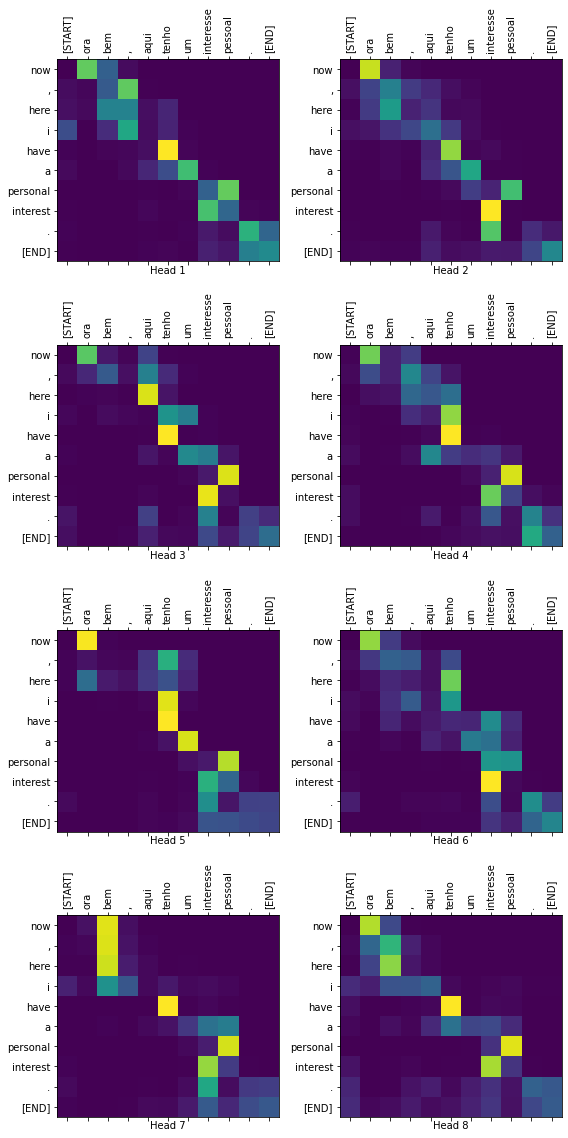

In [69]:
sentence = 'ora bem , aqui tenho um interesse pessoal .'
ground_truth = 'now here , i have a personal interest .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)
plot_attention_weights(sentence, translated_tokens, attention_weights['decoder_layer4_block2'][0])

Input:         : e assim foi . comecei no início de 2004 e terminei no final de 2011 .
Prediction     : and that was . i started in the beginning of 2004 , and i finished at the end of 2011 .
Ground truth   : and i went . i started in the beginning of 2004 , and i finished at the end of 2011 .


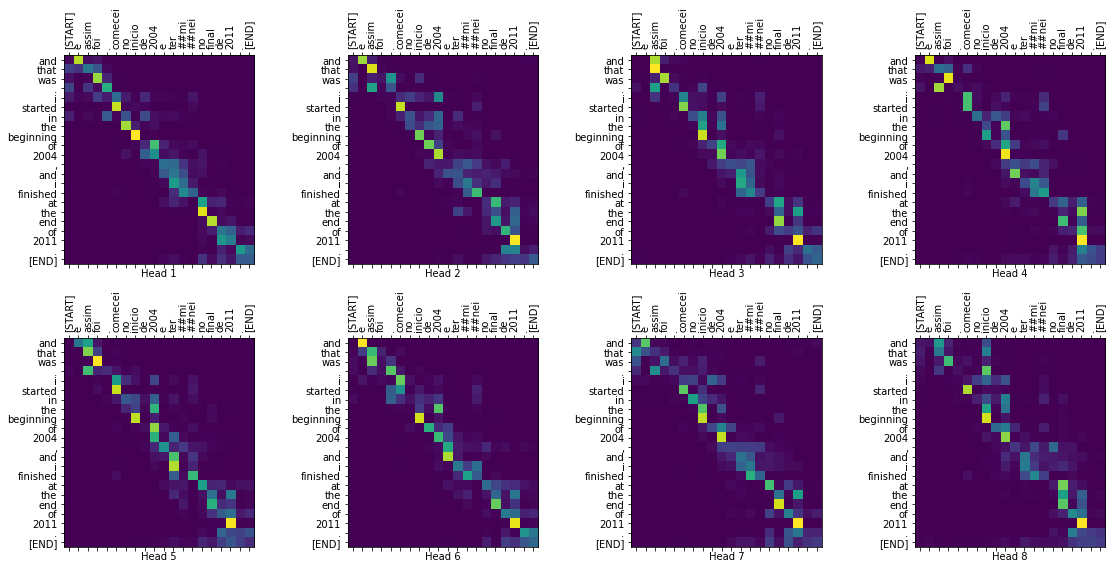

In [57]:
sentence = 'e assim foi . comecei no início de 2004 e terminei no final de 2011 .'
ground_truth = 'and i went . i started in the beginning of 2004 , and i finished at the end of 2011 .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)
plot_attention_weights(sentence, translated_tokens, attention_weights['decoder_layer4_block2'][0])

Input:         : deste modo , em vez de me focar apenas em algoritmos cada vez melhores , a minha ideia foi treinar os algoritmos com o mesmo tipo de dados que uma criança recebe através das suas experiências , tanto em quantidade como qualidade .
Prediction     : so about it time we focus on making time and more machine , and my idea was reurving the same machine with the same kind of data back from each of its quality through value , both quality as much as in the quality of quality .
Ground truth   : so instead of focusing solely on better and better algorithms , my insight was to give the algorithms the kind of training data that a child was given through experiences in both quantity and quality .


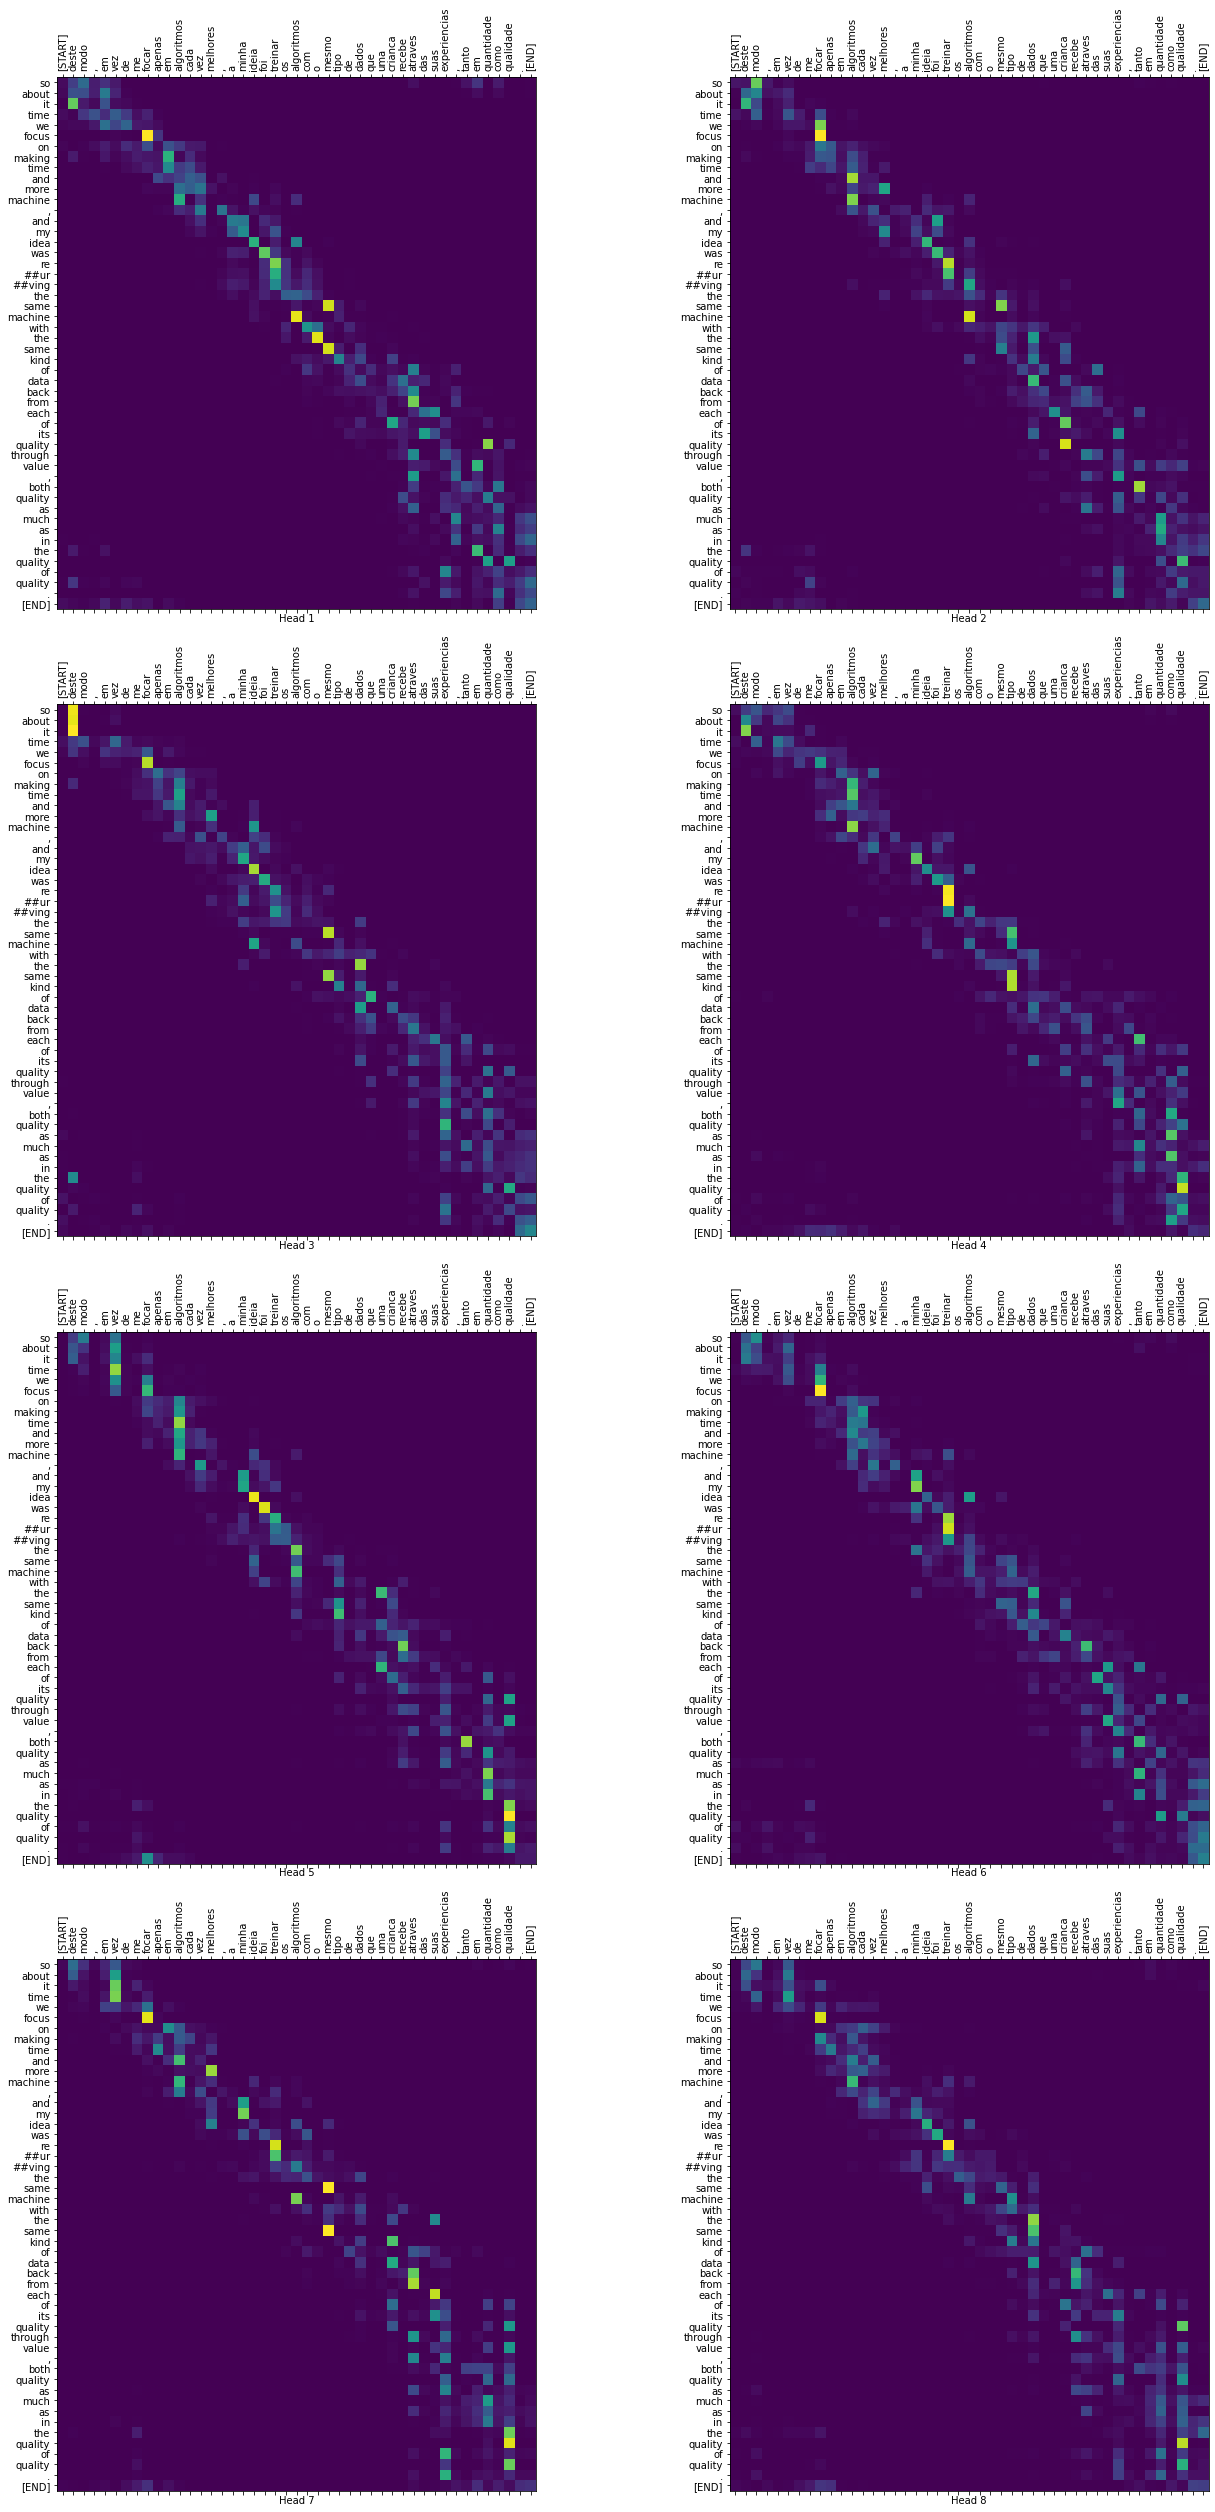

In [81]:
sentence = 'deste modo , em vez de me focar apenas em algoritmos cada vez melhores , a minha ideia foi treinar os algoritmos com o mesmo tipo de dados que uma criança recebe através das suas experiências , tanto em quantidade como qualidade .'
ground_truth = 'so instead of focusing solely on better and better algorithms , my insight was to give the algorithms the kind of training data that a child was given through experiences in both quantity and quality .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)
plot_attention_weights(sentence, translated_tokens, attention_weights['decoder_layer4_block2'][0])

In [82]:
for pt_sentences, en_sentences in x_test.shuffle(BUFFER_SIZE).batch(20).take(1):
  for pt, en in zip(pt_sentences.numpy(), en_sentences.numpy()):
    sentence = pt.decode('utf-8')
    ground_truth = en.decode('utf-8')

    translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
    print_translation(sentence, translated_text, ground_truth)
    print('----------------------------------------------------------------------------------------------------------')

Input:         : perdemos o medo de criar uma coisa nova .
Prediction     : we lost fear for making something new .
Ground truth   : we lost the fear of creating something new .
----------------------------------------------------------------------------------------------------------
Input:         : e mais do que isso , é uma combinação de diferentes ideias , a ideia do plástico , a ideia do laser , a ideia dos transístores .
Prediction     : and more than that , it ' s a different way of all the ideas of the plastic parts , the idea of showing the idea of the idea of medicine .
Ground truth   : and more than that , it 's a confection of different ideas , the idea of plastic , the idea of a laser , the idea of transistors .
----------------------------------------------------------------------------------------------------------
Input:         : é fácil para um cientista atirar-se sem ter ideia do que está a fazer porque isso é o que fazemos no laboratório , mas para um professor não 

Finito